##  Time Series Classification

In [510]:
from pandas import Series
import pandas as pd
import numpy as np
import scikits.bootstrap
import os
import seaborn as sb
import re
import matplotlib.pyplot as plt
from ggplot import *
from sklearn import metrics
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from scipy import interp
import sklearn.model_selection
from sklearn.feature_selection import chi2

In [3]:
# To order files as human sort
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
   
    return [ atoi(c) for c in re.split('(\d+)', text) ]


In [83]:
df = pd.read_csv('data/sitting/dataset8.csv', header=4)
df.head()

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,44.00,0.71,18.75,0.43,7.75,1.30
1,250,44.00,0.00,18.50,0.50,8.67,0.47
2,500,43.75,0.83,18.00,0.00,9.67,0.94
3,750,43.75,0.43,18.25,0.43,9.00,0.00
4,1000,43.75,0.43,18.00,0.00,9.00,0.00


In [84]:
featurelist=['mean','min','max','std','25%','50%','75%']
features=[]
for i in df.columns.values[1:]:
    for j in featurelist:
        features.append(i+"_"+j)
features.append('label')
print(features)

['avg_rss12_mean', 'avg_rss12_min', 'avg_rss12_max', 'avg_rss12_std', 'avg_rss12_25%', 'avg_rss12_50%', 'avg_rss12_75%', 'var_rss12_mean', 'var_rss12_min', 'var_rss12_max', 'var_rss12_std', 'var_rss12_25%', 'var_rss12_50%', 'var_rss12_75%', 'avg_rss13_mean', 'avg_rss13_min', 'avg_rss13_max', 'avg_rss13_std', 'avg_rss13_25%', 'avg_rss13_50%', 'avg_rss13_75%', 'var_rss13_mean', 'var_rss13_min', 'var_rss13_max', 'var_rss13_std', 'var_rss13_25%', 'var_rss13_50%', 'var_rss13_75%', 'avg_rss23_mean', 'avg_rss23_min', 'avg_rss23_max', 'avg_rss23_std', 'avg_rss23_25%', 'avg_rss23_50%', 'avg_rss23_75%', 'var_rss23_mean', 'var_rss23_min', 'var_rss23_max', 'var_rss23_std', 'var_rss23_25%', 'var_rss23_50%', 'var_rss23_75%', 'label']


In [85]:
df1= pd.DataFrame(columns=features)

In [94]:
folderlist=os.listdir('data')

k=0
for folder in folderlist:
    #print(folder)
    files=os.listdir('data/'+folder)
    files.sort(key=natural_keys)
    #print(files)
    for datafile in files:
        featureval=[]
        #print (datafile)
        df = pd.read_csv('data/'+folder+'/'+datafile, header=4)
        for i in range(1,7,1):
            for j in range(0,len(featurelist),1):
                values=df.describe()[df.columns.values[i]][featurelist[j]]
                featureval.append(values)
        df1.loc[k,features[:-1]]=featureval
        df1.loc[k,'label']=folder
        k=k+1
print("loaded data in df1")

loaded data in df1


In [95]:
df1.describe()

,avg_rss12_mean,avg_rss12_min,avg_rss12_max,avg_rss12_std,avg_rss12_25%,avg_rss12_50%,avg_rss12_75%,var_rss12_mean,var_rss12_min,var_rss12_max,...,avg_rss23_50%,avg_rss23_75%,var_rss23_mean,var_rss23_min,var_rss23_max,var_rss23_std,var_rss23_25%,var_rss23_50%,var_rss23_75%,label
count,88.000000,88.0,88.0,88.000000,88.0,88.0,88.0,88.000000,88.0,88.0,...,88.0,88.00,88.000000,88.0,88.0,88.0000,88.00,88.0,88.00,88
unique,81.000000,59.0,41.0,81.000000,48.0,47.0,47.0,81.000000,1.0,68.0,...,52.0,53.00,82.000000,2.0,70.0,82.0000,27.00,31.0,40.00,7
top,27.716375,39.0,45.0,1.442253,42.0,36.0,45.0,0.363688,0.0,1.0,...,16.0,18.25,0.734271,0.0,4.5,1.8526,0.43,0.5,0.83,lying
freq,3.000000,7.0,8.0,3.000000,8.0,8.0,7.0,3.000000,88.0,9.0,...,7.0,6.00,2.000000,87.0,4.0,2.0000,25.00,17.0,11.00,15


Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1,
2, and 3 in other folders as test data and other datasets as train data.


In [96]:
dftest=pd.DataFrame(columns=features)
for i in folderlist:
    if 'bending' in i:
        dftest=dftest.append(df1[df1.label == i][:2])
    else:
        dftest=dftest.append(df1[df1.label == i][:3])
dftrain = df1.drop(list(dftest.index.values))
dftrain=dftrain.reset_index(drop=True)
dftest=dftest.reset_index(drop=True)    

In [97]:
dftrain.describe()

,avg_rss12_mean,avg_rss12_min,avg_rss12_max,avg_rss12_std,avg_rss12_25%,avg_rss12_50%,avg_rss12_75%,var_rss12_mean,var_rss12_min,var_rss12_max,...,avg_rss23_50%,avg_rss23_75%,var_rss23_mean,var_rss23_min,var_rss23_max,var_rss23_std,var_rss23_25%,var_rss23_50%,var_rss23_75%,label
count,69.000000,69.0,69.0,69.000000,69.0,69.0,69.0,69.000000,69.0,69.0,...,69.0,69.00,69.000000,69.0,69.00,69.000000,69.00,69.0,69.00,69
unique,65.000000,46.0,36.0,65.000000,43.0,41.0,40.0,65.000000,1.0,54.0,...,44.0,46.00,66.000000,2.0,57.00,66.000000,23.00,26.0,36.00,7
top,39.667833,39.0,45.0,0.208558,42.0,36.0,45.0,0.583604,0.0,1.0,...,16.0,18.25,0.766167,0.0,6.36,0.438442,0.43,0.5,0.83,lying
freq,2.000000,7.0,5.0,2.000000,6.0,7.0,7.0,2.000000,69.0,8.0,...,7.0,6.00,2.000000,68.0,3.00,2.000000,20.00,14.0,10.00,12


## (c) Feature Extraction

### Simple statistical features

* *Means* in each of the d dimensions
* *Standard deviations* of the d dimensions
* *Skewness, Kurtosis* and Higher order moments of the d dimensions
* *Maximum* and *Minimum* values

### Time series analysis related features

* The d×d−1 Cross-Correlations between each dimension and the d Auto-Correlations-
* Orders of the autoregressive (AR), integrated (I) and moving average (MA) part of an estimated ARIMA model
* Parameters of the AR part
* Parameters of the MA part

### Frequency domain related features

* frequencies of the k peaks in amplitude in the DFTs for the detrended d dimensions
* k-quantiles of these DFTs

In [69]:
featureset1=['avg_rss12_mean', 'avg_rss12_min', 'avg_rss12_max', 'avg_rss12_std', 'avg_rss12_25%', 'avg_rss12_50%', 'avg_rss12_75%']


### Bootstrap and confidence interval for Standard Deviation

In [70]:

intervals=[]
for i in dftrain.columns.values[:-1]:
    stdlist=[]
    for count in range(len(dftrain[i])):
        stdlist.append(np.random.choice(dftrain[i], len(dftrain[i])).std())
    intervals.append(scikits.bootstrap.ci(stdlist,n_samples=1000))

C:\Users\tanay\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: InstabilityWarning: BCa acceleration values for indexes (array([0], dtype=int64),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  import sys
C:\Users\tanay\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  import sys
C:\Users\tanay\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: InstabilityWarning: BCa acceleration values for indexes (array([0], dtype=int64),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  import sys
C:\Users\tanay\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  import sys


In [71]:
for i in range(len(intervals)):
    print(str(dftrain.columns.values[i])+"  "+str(dftrain.std()[i])+"  "+str(intervals[i]))

avg_rss12_mean  4.91769699386  [ 4.75566348  4.90859455]
avg_rss12_min  8.79429486459  [ 8.38882622  8.69307243]
avg_rss12_max  4.42918152931  [ 4.18343219  4.48156284]
avg_rss12_std  1.7586316537  [ 1.68106493  1.73022859]
avg_rss12_25%  5.73126206942  [ 5.55563196  5.69457575]
avg_rss12_50%  4.95611090199  [ 4.78855605  4.96771721]
avg_rss12_75%  4.78364513319  [ 4.59118888  4.83198912]
var_rss12_mean  1.60066807967  [ 1.55738712  1.60728335]
var_rss12_min  0.0  [ 0.  0.]
var_rss12_max  5.14784141438  [ 4.99317806  5.10529762]
var_rss12_std  0.902767261969  [ 0.88405455  0.90571201]
var_rss12_25%  0.952200638549  [ 0.91801748  0.95457887]
var_rss12_50%  1.43690261689  [ 1.38157106  1.42435784]
var_rss12_75%  2.15825839013  [ 2.11477741  2.16785247]
avg_rss13_mean  3.86331266689  [ 3.72380521  3.89664785]
avg_rss13_min  3.05386906776  [ 2.9470283   3.01478952]
avg_rss13_max  4.75985339562  [ 4.53254222  4.76253253]
avg_rss13_std  0.995990451013  [ 0.94059503  0.99541418]
avg_rss13_25%

### Selected : Mean, First Quartile (25%) and Third Quartile (75%)
As values for min were 0, took 25%. Similarly, 75% instead of max to reduce outliers, and mean to get an estimate of min and max range.

In [72]:
newfeaturelist=['mean','25%','75%']

In [80]:
newfeatures=[]
for i in df.columns.values[1:-1]:
    for j in newfeaturelist:
        newfeatures.append(i+"_"+j)
newfeatures.append('label')
print(newfeatures)

['avg_rss12_mean', 'avg_rss12_25%', 'avg_rss12_75%', 'var_rss12_mean', 'var_rss12_25%', 'var_rss12_75%', 'avg_rss13_mean', 'avg_rss13_25%', 'avg_rss13_75%', 'var_rss13_mean', 'var_rss13_25%', 'var_rss13_75%', 'avg_rss23_mean', 'avg_rss23_25%', 'avg_rss23_75%', 'var_rss23_mean', 'var_rss23_25%', 'var_rss23_75%', 'label']


In [81]:
df2=df1[newfeatures]
df2.head()

,avg_rss12_mean,avg_rss12_25%,avg_rss12_75%,var_rss12_mean,var_rss12_25%,var_rss12_75%,avg_rss13_mean,avg_rss13_25%,avg_rss13_75%,var_rss13_mean,var_rss13_25%,var_rss13_75%,avg_rss23_mean,avg_rss23_25%,avg_rss23_75%,var_rss23_mean,var_rss23_25%,var_rss23_75%,label
0,40.6248,39.25,42,0.358604,0,0.5,19.0409,16,23.25,0.832542,0,1.12,34.3113,33,36,0.570583,0,1.3,bending1
1,42.8128,42,43.67,0.372438,0,0.5,20.097,19,22.25,0.876438,0,1.145,33.0246,32,34.5,0.571083,0,1.3,bending1
2,43.9545,43,45,0.42625,0,0.5,22.1224,19.75,24,0.497313,0,0.83,35.5885,35.3625,36.5,0.493292,0,0.94,bending1
3,42.1798,39.15,45,0.696042,0,1.12,22.1836,20.5,24.3725,0.989917,0.43,1.3,33.4939,30.4575,36.33,0.613521,0,1,bending1
4,41.6781,41.33,42.75,0.535979,0.43,0.71,19.0066,16.5,22.0625,0.841875,0.43,1.12,29.8571,28.4575,31.25,0.383292,0,0.5,bending1


### Features extracted from time series 1, 2, and 6

In [82]:
feature126=[]
for i in df.columns.values[[1,2,6]]:
    for j in newfeaturelist:
        feature126.append(i+"_"+j)
feature126.append('label')
feature126

['avg_rss12_mean',
 'avg_rss12_25%',
 'avg_rss12_75%',
 'var_rss12_mean',
 'var_rss12_25%',
 'var_rss12_75%',
 'var_rss23_mean',
 'var_rss23_25%',
 'var_rss23_75%',
 'label']

In [18]:
df3=df2[feature126]
df3.describe()

,avg_rss12_mean,avg_rss12_25%,avg_rss12_75%,var_rss12_mean,var_rss12_25%,var_rss12_75%,var_rss23_mean,var_rss23_25%,var_rss23_75%,label
count,88.000000,88.0,88.0,88.000000,88.0,88.0,88.000000,88.00,88.00,88
unique,81.000000,48.0,47.0,81.000000,22.0,38.0,82.000000,27.00,40.00,7
top,27.716375,42.0,45.0,0.363688,0.0,0.5,0.734271,0.43,0.83,lying
freq,3.000000,8.0,7.0,3.000000,41.0,38.0,2.000000,25.00,11.00,15


In [65]:
dftest=pd.DataFrame(columns=feature126)
for i in folderlist:
    if 'bending' in i:
        dftest=dftest.append(df3[df3.label == i][:2])
    else:
        dftest=dftest.append(df3[df3.label == i][:3])
dftrain = df3.drop(list(dftest.index.values))
dftrain=dftrain.reset_index(drop=True)
dftest=dftest.reset_index(drop=True)    

In [66]:
dftrain.head()

,avg_rss12_mean,avg_rss12_25%,avg_rss12_75%,var_rss12_mean,var_rss12_25%,var_rss12_75%,var_rss23_mean,var_rss23_25%,var_rss23_75%,label
0,40.624792,39.25,42.00,0.358604,0.00,0.50,0.570583,0.0,1.30,bending
1,42.812812,42.00,43.67,0.372438,0.00,0.50,0.571083,0.0,1.30,bending
2,43.954500,43.00,45.00,0.426250,0.00,0.50,0.493292,0.0,0.94,bending
3,42.179813,39.15,45.00,0.696042,0.00,1.12,0.613521,0.0,1.00,bending
4,41.678063,41.33,42.75,0.535979,0.43,0.71,0.383292,0.0,0.50,bending


## Combining full time series

In [21]:
folderlist=os.listdir('data')
df_fulltrain=pd.DataFrame()
df_fulltest=pd.DataFrame()
k=0
for folder in folderlist:
    #print(folder)
    files=os.listdir('data/'+folder)
    files.sort(key=natural_keys)
    #print(files)
    df_train=pd.DataFrame()
    df_test=pd.DataFrame()
    for datafile in files:
        featureval=[]
        #print (datafile)
        df = pd.read_csv('data/'+folder+'/'+datafile, header=4)
        if ( datafile == "dataset2.csv" or datafile == "dataset1.csv" or datafile == "dataset3.csv"):
            if(folder=="bending1" or folder =="bending2"):
                if (datafile=="dataset3.csv"):
                    df["label"]=folder
                    df_train=df_train.append(df)
                else:
                    df["label"]=folder
                    df_test=df_test.append(df)
            else: 
                df["label"]=folder
                df_test=df_test.append(df)
        else:
            df["label"]=folder
            df_train=df_train.append(df)
            
    df_fulltrain=df_fulltrain.append(df_train)
    df_fulltest=df_fulltest.append(df_test)


In [22]:
df_fulltrain=df_fulltrain.reset_index(drop=True)
df_fulltest=df_fulltest.reset_index(drop=True)

In [98]:
df_fulltrain.describe()

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
count,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000
mean,59875.000000,39.005375,1.510162,14.166451,1.505288,15.669726,1.644087
std,34641.463948,5.986590,2.082418,5.346525,1.648239,6.287250,1.646946
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29937.500000,35.250000,0.430000,11.500000,0.430000,12.000000,0.470000
50%,59875.000000,39.670000,0.500000,14.750000,0.830000,15.670000,1.000000
75%,89812.500000,43.500000,1.920000,18.000000,2.290000,18.750000,2.380000
max,119750.000000,56.250000,17.240000,32.750000,11.420000,40.330000,13.610000


## (d) Binary Classification Using Logistic Regression


(i) Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities.

In [23]:
df3=df3.replace(['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing','walking'],['bending', 'bending', 'notbending', 'notbending', 'notbending', 'notbending','notbending'])
#df2=df2.replace(['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing','walking'],['bending', 'bending', 'notbending', 'notbending', 'notbending', 'notbending','notbending'])

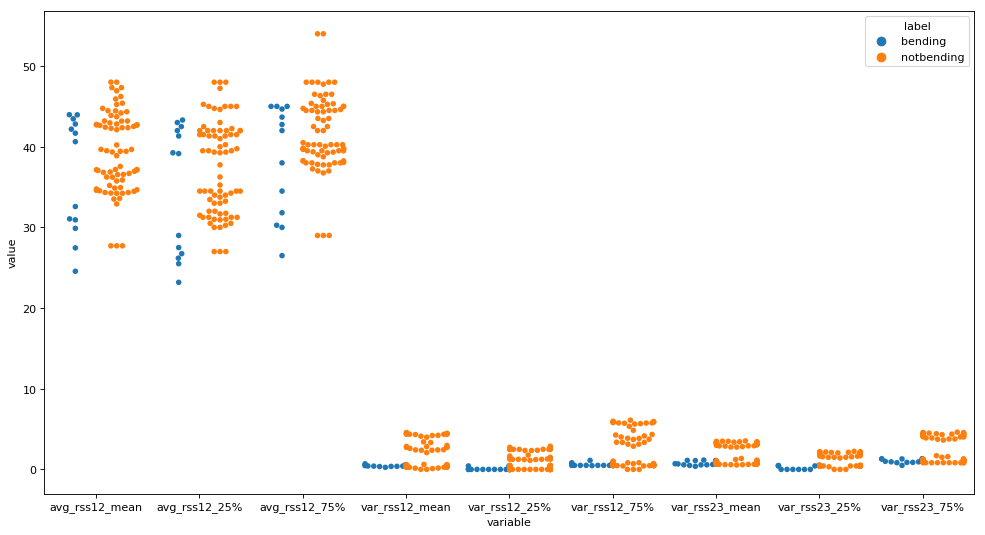

In [28]:
dfplt=pd.melt(df3,id_vars='label',value_vars=feature126[:-1])
plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
sb.swarmplot(x='variable',y='value',hue='label',size=5,data=dfplt,dodge=True)
plt.show()

In [101]:
dftrainl=dftrain
dftestl=dftest

In [102]:
dftrainl=dftrainl.replace(['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing',
       'walking'],['bending', 'bending', 'notbending', 'notbending', 'notbending', 'notbending',
       'notbending'])
dftestl=dftestl.replace(['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing',
       'walking'],['bending', 'bending', 'notbending', 'notbending', 'notbending', 'notbending',
       'notbending'])

In [33]:
def keylist(setsize,L):
    listall=[]
    for i in range(0,setsize,1):
        listall.append(range(i*480,((i+1)*480)))
    listL=[]
    for i in listall:
        listL.extend(np.array_split(np.array(i), L))
    return listL;

In [34]:
def df_Lsplit(passdf,L):
    splits=keylist(int(passdf.shape[0]/480),L)
    dfnew=pd.DataFrame(columns=newfeatures)
    splitcol=['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23','var_rss23']
    k=0
    for i in splits:
        split=passdf.iloc[i]
        desc=split.describe()
        featureval=[]
        for column in splitcol:
            values=desc.loc[newfeaturelist][column]
            featureval+=(list(values))
        featureval.append(split.label.unique()[0])
        dfnew.loc[k]=featureval
        k=k+1
    return dfnew;

In [110]:
df4=df_Lsplit(df_fulltrain,2)
df4=df4.replace(['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing',
       'walking'],['bending', 'bending', 'notbending', 'notbending', 'notbending', 'notbending',
       'notbending'])
dfplt=pd.melt(df4[feature126],id_vars='label',value_vars=feature126[:-1])

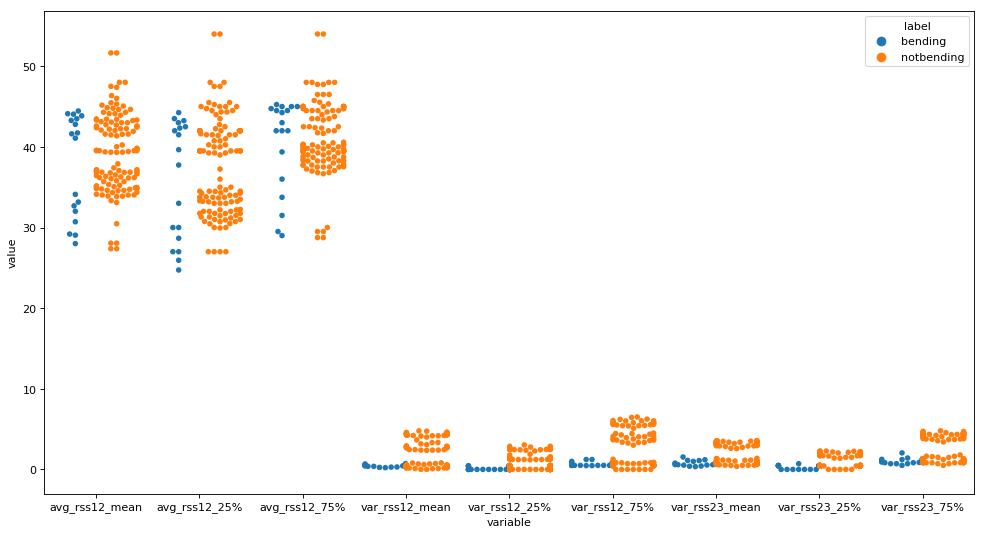

In [111]:
plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
sb.swarmplot(x='variable',y='value',hue='label',size=5,data=dfplt,dodge=True)
plt.show()

### There are more instances which help us get a better idea of the actual distribution, outliers  

In [112]:
#dftrainl=dftrainl.replace(['bending','notbending'],['0','1'])
dftrainl=dftrainl[newfeatures]
dftestl=dftestl[newfeatures]

In [113]:
df_l1=df_Lsplit(df_fulltrain,1).replace(['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing',
       'walking'],[0,0,1,1,1,1,1])

In [257]:
logreg = linear_model.LogisticRegression(C=100000)
logreg.fit(df_l1[newfeatures[:-1]], df_l1['label'])

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## Wrong way

* CV only after feature selection is done and not including features


## Correct way to cross validate

* Cross validate both before selecting the predictors and while classification using them



In [124]:
for L in range(1,11):
    df_l=df_Lsplit(df_fulltrain,L).replace(['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing','walking'],[0,0,1,1,1,1,1])
    rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=0)
    rep=1
    avg=0
    for train, test in rkf.split(df_l):
        print("Round:"+str(rep))
        rep=rep+1
        logreg.fit(df_l.loc[train][newfeatures[:-1]],df_l.loc[train].label)
        score=logreg.score(df_l.loc[test][newfeatures[:-1]],df_l.loc[test].label.astype(int))
        avg+=score
        print("Score :"+str(score))
        
    avg=avg/5
    print(".................................Average score for L="+str(L)+" is  "+str(avg))


Round:1
Score :0.785714285714
Round:2
Score :0.857142857143
Round:3
Score :0.928571428571
Round:4
Score :0.857142857143
Round:5
Score :1.0
.................................Average score for L=1 is  0.885714285714
Round:1
Score :0.857142857143
Round:2
Score :0.857142857143
Round:3
Score :0.892857142857
Round:4
Score :0.925925925926
Round:5
Score :0.777777777778
.................................Average score for L=2 is  0.862169312169
Round:1
Score :0.928571428571
Round:2
Score :0.833333333333
Round:3
Score :0.926829268293
Round:4
Score :0.878048780488
Round:5
Score :0.951219512195
.................................Average score for L=3 is  0.903600464576
Round:1
Score :1.0
Round:2
Score :0.890909090909
Round:3
Score :0.927272727273
Round:4
Score :0.872727272727
Round:5
Score :0.945454545455
.................................Average score for L=4 is  0.927272727273
Round:1
Score :0.95652173913
Round:2
Score :0.971014492754
Round:3
Score :0.927536231884
Round:4
Score :0.898550724638
Round:5

## Best Values of L from the accuracy are L=10

Running on complete training set

In [180]:
selected_features=[]
df_l=df_Lsplit(df_fulltrain,10).replace(['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing','walking'],[0,0,1,1,1,1,1])
logit = chi2(df_l[newfeatures[:-1]],df_l.label)
for i in range(len(logit[1])):
    if logit[1][i] < 0.05:
        print(df_l.columns[i]+" p-value: "+str(logit[1][i]))
        selected_features.append(df_l.columns[i])
selected_features.append("label")

avg_rss12_mean p-value: 0.0399930889869
avg_rss12_75% p-value: 0.00402506979073
var_rss12_mean p-value: 2.42358847029e-18
var_rss12_25% p-value: 3.51576842437e-14
var_rss12_75% p-value: 4.54285587269e-23
avg_rss13_mean p-value: 4.99114334591e-09
avg_rss13_25% p-value: 7.5833103949e-09
avg_rss13_75% p-value: 4.7399297579e-10
var_rss13_mean p-value: 7.181583668e-10
var_rss13_25% p-value: 2.03905480891e-10
var_rss13_75% p-value: 1.33016356719e-12
avg_rss23_mean p-value: 6.23715744555e-100
avg_rss23_25% p-value: 1.11381866983e-117
avg_rss23_75% p-value: 3.91491798296e-84
var_rss23_mean p-value: 1.72618876205e-12
var_rss23_25% p-value: 3.6657551421e-11
var_rss23_75% p-value: 8.60543819503e-15


In [154]:
#selected_features=['var_rss12_75%','avg_rss23_mean','avg_rss23_25%','avg_rss23_75%','label']
df_select=df_l[selected_features]

In [155]:
logreg.fit(df_select[selected_features[:-1]], df_select['label'])

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [156]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=0)
rep=1
avg=0
for train, test in rkf.split(df_select):
    print("Round:"+str(rep))
    rep=rep+1
    logreg.fit(df_select.loc[train][selected_features[:-1]],df_select.loc[train].label)
    score=logreg.score(df_select.loc[test][selected_features[:-1]],df_select.loc[test].label.astype(int))
    avg+=score
    print("Score :"+str(score))
avg=avg/5
print(avg)

Round:1
Score :0.942028985507
Round:2
Score :0.949275362319
Round:3
Score :0.978260869565
Round:4
Score :0.913043478261
Round:5
Score :0.963768115942
0.949275362319


In [158]:
logreg.fit(df_select[selected_features[:-1]],df_select.label)
y_pred=logreg.predict(df_select[selected_features[:-1]])

In [161]:
cm = confusion_matrix(df_select.label,y_pred)
print(cm)

[[ 73  17]
 [ 10 590]]


*true positive  | false negative*

*false positive | true negative*
### Total 690 instances
#### out of 90 instances of bending 73 were predicted correctly and 17 was misclassified
#### out of 600 instances of notbending 10 were misclassified and 590 were classified correctly.

In [211]:
logit2 = chi2(df_select[selected_features[:-1]],df_select.label)

In [227]:
prob = logreg.predict_proba(df_select[selected_features[:-1]])
False_Positive_rate, True_Positive_rate, _ = metrics.roc_curve(df_select.label,prob[:,1])
df_c = pd.DataFrame(dict(False_Positive_rate=False_Positive_rate, True_Positive_rate=True_Positive_rate))
print("the AUC for the given curve is ",metrics.auc(False_Positive_rate,True_Positive_rate),"\n")
print("The coeffecients of the model are",logreg.coef_,"\n")
print("The associated p values are",logit2[1],"\n")

the AUC for the given curve is  0.984074074074 

The coeffecients of the model are [[ 0.35644523 -0.06054905  2.47478531  2.25427065 -0.18822129 -0.65837997
   0.45879998  0.32319276 -5.85321496  3.5819255   2.46752573 -2.0546381
   0.67155492  0.74196049 -1.45267538  2.64694622 -0.86020483]] 

The associated p values are [  3.99930890e-002   4.02506979e-003   2.42358847e-018   3.51576842e-014
   4.54285587e-023   4.99114335e-009   7.58331039e-009   4.73992976e-010
   7.18158367e-010   2.03905481e-010   1.33016357e-012   6.23715745e-100
   1.11381867e-117   3.91491798e-084   1.72618876e-012   3.66575514e-011
   8.60543820e-015] 



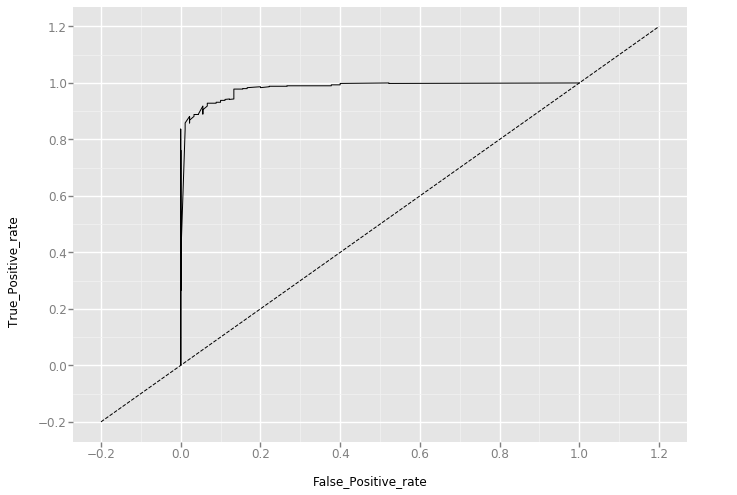

<ggplot: (-9223371950369403171)>

In [228]:
ggplot(df_c, aes(x='False_Positive_rate', y='True_Positive_rate'))\
+ geom_line() \
+ geom_abline(linetype='dashed')   

In [182]:
df_ltest=df_Lsplit(df_fulltest,10).replace(['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing','walking'],[0,0,1,1,1,1,1])
df_ltest=df_ltest[selected_features]

In [183]:
y_pred_test=logreg.predict(df_ltest[selected_features[:-1]])

In [191]:
scores= metrics.accuracy_score(df_ltest.label,y_pred_test)
print("Accuracy on test set with L = 10 is",scores)

Accuracy on test set with L = 10 is 0.973684210526


### Test accuracy compared to CV is much better at 97.37% compared to 94.7%

## Separation
The more predictors are in the model, the more likely separation is to occur because the individual groups in the data have smaller sample sizes.

Essentially, separation occurs when there is a category or range of a predictor with only one value of the response. We need diversity, or variation among the response to estimate the model. 

## Imbalance

Although for L=10, I have 90 values for **bending** but it still is less compared to 600 **notbending**.
Stratified Sampling is the solution to this.

In [239]:
#a,b= sklearn.model_selection.train_test_split(df_select,stratify=df_select.label)

### We can overcome imbalance by having weighted classes (Balance) as we do not have more data for *bending*
#### Another way is Over sampling

In [254]:
logreg_bal = linear_model.LogisticRegression(C=100000,class_weight ='balanced')

In [255]:
logreg_bal.fit(df_select[selected_features[:-1]],df_select.label)
y_pred=logreg_bal.predict(df_select[selected_features[:-1]])

In [256]:
cm = confusion_matrix(df_select.label,y_pred)
print(metrics.accuracy_score(df_select.label,y_pred))
print(cm)

0.944927536232
[[ 85   5]
 [ 33 567]]


### As you can see we now have a balanced error rate for both bending and notbending

The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

## L1 penalized model

In [270]:
logreg_l1 = linear_model.LogisticRegression(penalty='l1', solver = 'liblinear' )

In [447]:
cs_score=[]
for L in range(1,11):
    df_l=df_Lsplit(df_fulltrain,L).replace(['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing','walking'],[0,0,1,1,1,1,1])
    rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=0)
    rep=1
    avg=0
    for train, test in rkf.split(df_l):
        print("Round:"+str(rep))
        rep=rep+1
        logreg_l1 = linear_model.LogisticRegressionCV(penalty='l1', Cs=10, solver = 'liblinear' )
        logreg_l1.fit(df_l.loc[train][newfeatures[:-1]],df_l.loc[train].label)
        score=logreg_l1.score(df_l.loc[test][newfeatures[:-1]],df_l.loc[test].label.astype(int))
        cval=logreg_l1.C_
        avg+=score
        print("Score :"+str(score),"C value",cval)
        cs = logreg_l1.coef_
        cs_score.append(cs) 
    avg=avg/5
    print(".................................Average score for L="+str(L)+" is  "+str(avg))


Round:1
Score :0.928571428571 C value [ 0.35938137]
Round:2
Score :0.857142857143 C value [ 0.35938137]
Round:3
Score :0.928571428571 C value [ 0.35938137]
Round:4
Score :0.928571428571 C value [ 0.35938137]
Round:5
Score :1.0 C value [ 0.35938137]
.................................Average score for L=1 is  0.928571428571
Round:1
Score :0.964285714286 C value [ 0.35938137]
Round:2
Score :0.928571428571 C value [ 0.35938137]
Round:3
Score :0.928571428571 C value [ 1291.54966501]
Round:4
Score :1.0 C value [ 0.35938137]
Round:5
Score :0.851851851852 C value [ 0.35938137]
.................................Average score for L=2 is  0.934656084656
Round:1
Score :0.952380952381 C value [ 0.35938137]
Round:2
Score :0.880952380952 C value [ 0.35938137]
Round:3
Score :0.951219512195 C value [ 0.35938137]
Round:4
Score :0.926829268293 C value [ 0.35938137]
Round:5
Score :0.975609756098 C value [ 0.35938137]
.................................Average score for L=3 is  0.937398373984
Round:1
Score :0.

In [453]:
l1_selected_ftrs=[]
for i in cs_score[30:35]:
    for j in i:
        for k in range(len(j)):
            if j[k] == 0:
                l1_selected_ftrs.append(df_l.columns[k])
l1_selected_ftrs=set(l1_selected_ftrs)
l1_selected_ftrs=list(df_l.columns[[0,3,4,6,7,8,9,10,11,13,15,16,17,18]])

In [454]:
l1_selected_ftrs

['avg_rss12_mean',
 'var_rss12_mean',
 'var_rss12_25%',
 'avg_rss13_mean',
 'avg_rss13_25%',
 'avg_rss13_75%',
 'var_rss13_mean',
 'var_rss13_25%',
 'var_rss13_75%',
 'avg_rss23_25%',
 'var_rss23_mean',
 'var_rss23_25%',
 'var_rss23_75%',
 'label']

### Normalize data

In [324]:
scaler = StandardScaler()

In [338]:
df_l1train[['avg_rss12_mean','var_rss12_mean','avg_rss13_mean','var_rss13_mean','avg_rss23_25%','avg_rss13_75%']]=scaler.fit_transform(df_l1train[['avg_rss12_mean','var_rss12_mean','avg_rss13_mean','var_rss13_mean','avg_rss23_25%','avg_rss13_75%']])

## Best CV score for L=7

In [456]:
df_l1train=df_Lsplit(df_fulltrain,7).replace(['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing','walking'],[0,0,1,1,1,1,1])
df_l1train=df_l1train[l1_selected_ftrs]
df_l1test=df_Lsplit(df_fulltest,7).replace(['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing','walking'],[0,0,1,1,1,1,1])
df_l1test=df_ltest[l1_selected_ftrs]

In [457]:
#logreg_l1 = linear_model.LogisticRegression(penalty='l1', Cs=10, solver = 'liblinear' )
logreg_l1.fit(df_l1train[l1_selected_ftrs[:-1]],df_l1train.label)
score=logreg_l1.score(df_l1test[l1_selected_ftrs[:-1]],df_l1test.label.astype(int))

In [459]:
print("best C value",logreg_l1.C_)

best C value [ 0.04641589]


In [458]:
print("Accuracy score for L= 7 is ",score)

Accuracy score for L= 7 is  0.978947368421


### I found L1 penalization easier as we donot have to monitor p values and it automatically does C selection
### however it is more computationally expensive than backward selection

## F.i. Multi Class Classification

In [461]:
df_mctrain=df_Lsplit(df_fulltrain,7)
df_mctrain=df_mctrain[l1_selected_ftrs]
df_mctest=df_Lsplit(df_fulltest,7)
df_mctest=df_mctest[l1_selected_ftrs]

In [513]:
clf = linear_model.LogisticRegression(C=0.04641589,multi_class='multinomial',penalty='l1', solver='saga', tol=0.1)
clf.fit(df_mctrain[l1_selected_ftrs[:-1]], df_mctrain.label)

LogisticRegression(C=0.04641589, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False)

In [514]:
score = clf.score(df_mctest[l1_selected_ftrs[:-1]], df_mctest.label)

In [515]:
score

0.75187969924812026

In [466]:
predicted_val = clf.predict(df_mctest[l1_selected_ftrs[:-1]])
cm = confusion_matrix(df_mctest.label,predicted_val)
print(cm)

[[14  0  0  0  0  0  0]
 [10  0  4  0  0  0  0]
 [ 0  0 21  0  0  0  0]
 [ 0  0  0 19  2  0  0]
 [ 0  0  0  2 15  4  0]
 [ 0  0  0  5  5 11  0]
 [ 0  0  0  0  0  0 21]]


In [ ]:
y = label_binarize(df_mctrain.label, classes=['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking'])
n_classes = y.shape[1]

In [489]:
random_state = np.random.RandomState(0)
n_samples, n_features = df_mctrain[l1_selected_ftrs[:-1]].shape
X = np.c_[df_mctrain[l1_selected_ftrs[:-1]], random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [491]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

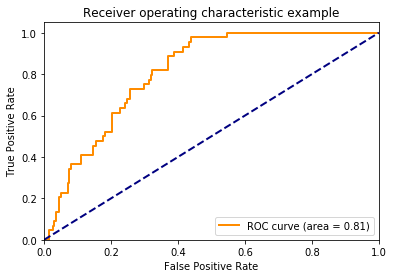

In [492]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## ii  Na¨ıve Bayes’ classiﬁer

### Using Gaussian

In [507]:

gnb = GaussianNB()
y_pred = gnb.fit(df_mctrain[l1_selected_ftrs[:-1]],df_mctrain.label).predict(df_mctest[l1_selected_ftrs[:-1]])
GaussianNBscore = metrics.accuracy_score(df_mctest.label,y_pred) 
print("Test score with L1 penalty on a entire train set: %.4f" % GaussianNBscore)
print("Test error with L1 penalty for entire train set: %.4f" % (1-GaussianNBscore))



Test score with L1 penalty on a entire train set: 0.8195
Test error with L1 penalty for entire train set: 0.1805


### Using Multinomial

In [508]:

from sklearn.naive_bayes import MultinomialNB


mnb = MultinomialNB()
y_pred = mnb.fit(df_mctrain[l1_selected_ftrs[:-1]],df_mctrain.label).predict(df_mctest[l1_selected_ftrs[:-1]])
MNscore = metrics.accuracy_score(df_mctest.label, y_pred) 
print("Test score with L1 penalty on a entire train set: %.4f" % MNscore)
print("Test error with L1 penalty for entire train set: %.4f" % (1-MNscore))


Test score with L1 penalty on a entire train set: 0.7444
Test error with L1 penalty for entire train set: 0.2556


## Found Gaussian Naive Bayes to be better simply for the accuracy

## ISLR 3.7.4

(a) I would expect the polynomial regression to have a lower training RSS
than the linear regression because it could make a tighter fit against data that
matched with a wider irreducible error (Var(epsilon)).

(b) Converse to (a), I would expect the polynomial regression to have a higher
test RSS as the overfit from training would have more error than the linear
regression.

(c) Polynomial regression has lower train RSS than the linear fit because of
higher flexibility: no matter what the underlying true relationship is the
more flexible model will closer follow points and reduce train RSS.

(d) There is not enough information to tell which test RSS would be lower
for either regression given the problem statement is defined as not knowing
"how far it is from linear". If it is closer to linear than cubic, the linear
regression test RSS could be lower than the cubic regression test RSS.
Or, if it is closer to cubic than linear, the cubic regression test RSS
could be lower than the linear regression test RSS. It is dues to
bias-variance tradeoff: it is not clear what level of flexibility will
fit data better.


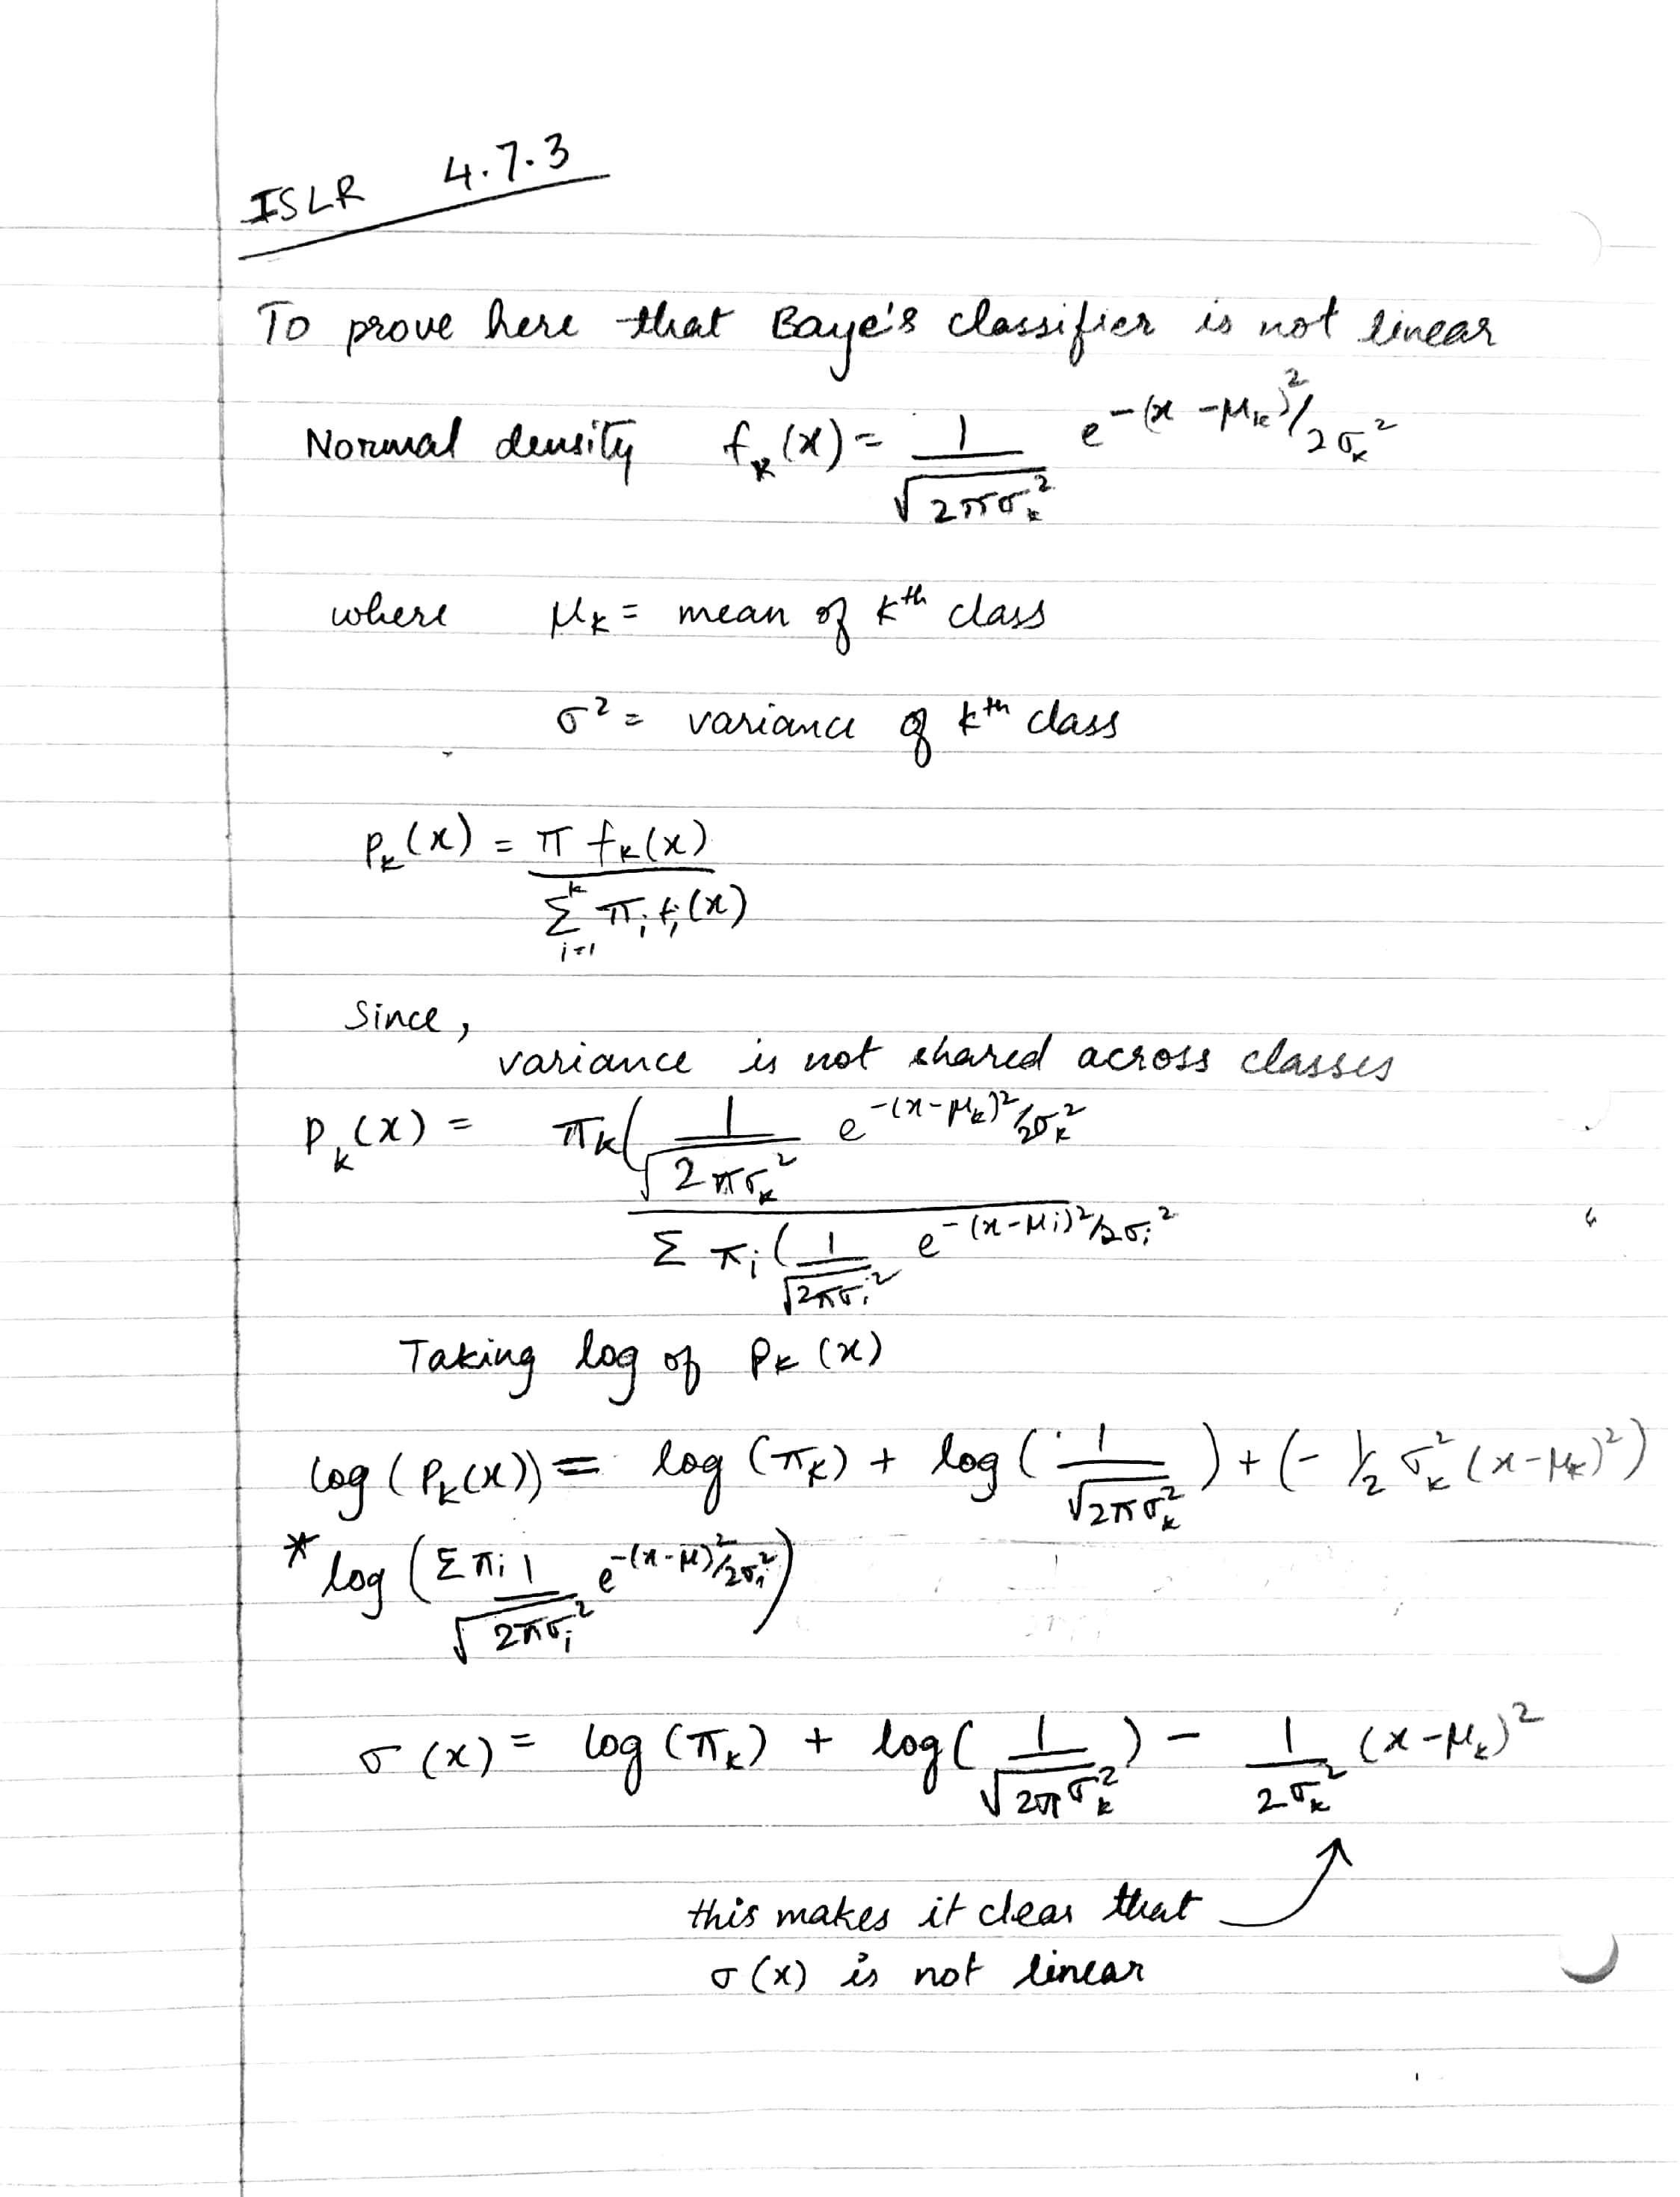

In [348]:
from IPython.display import Image, display; display(Image(filename=r'4.7.3.jpg'))

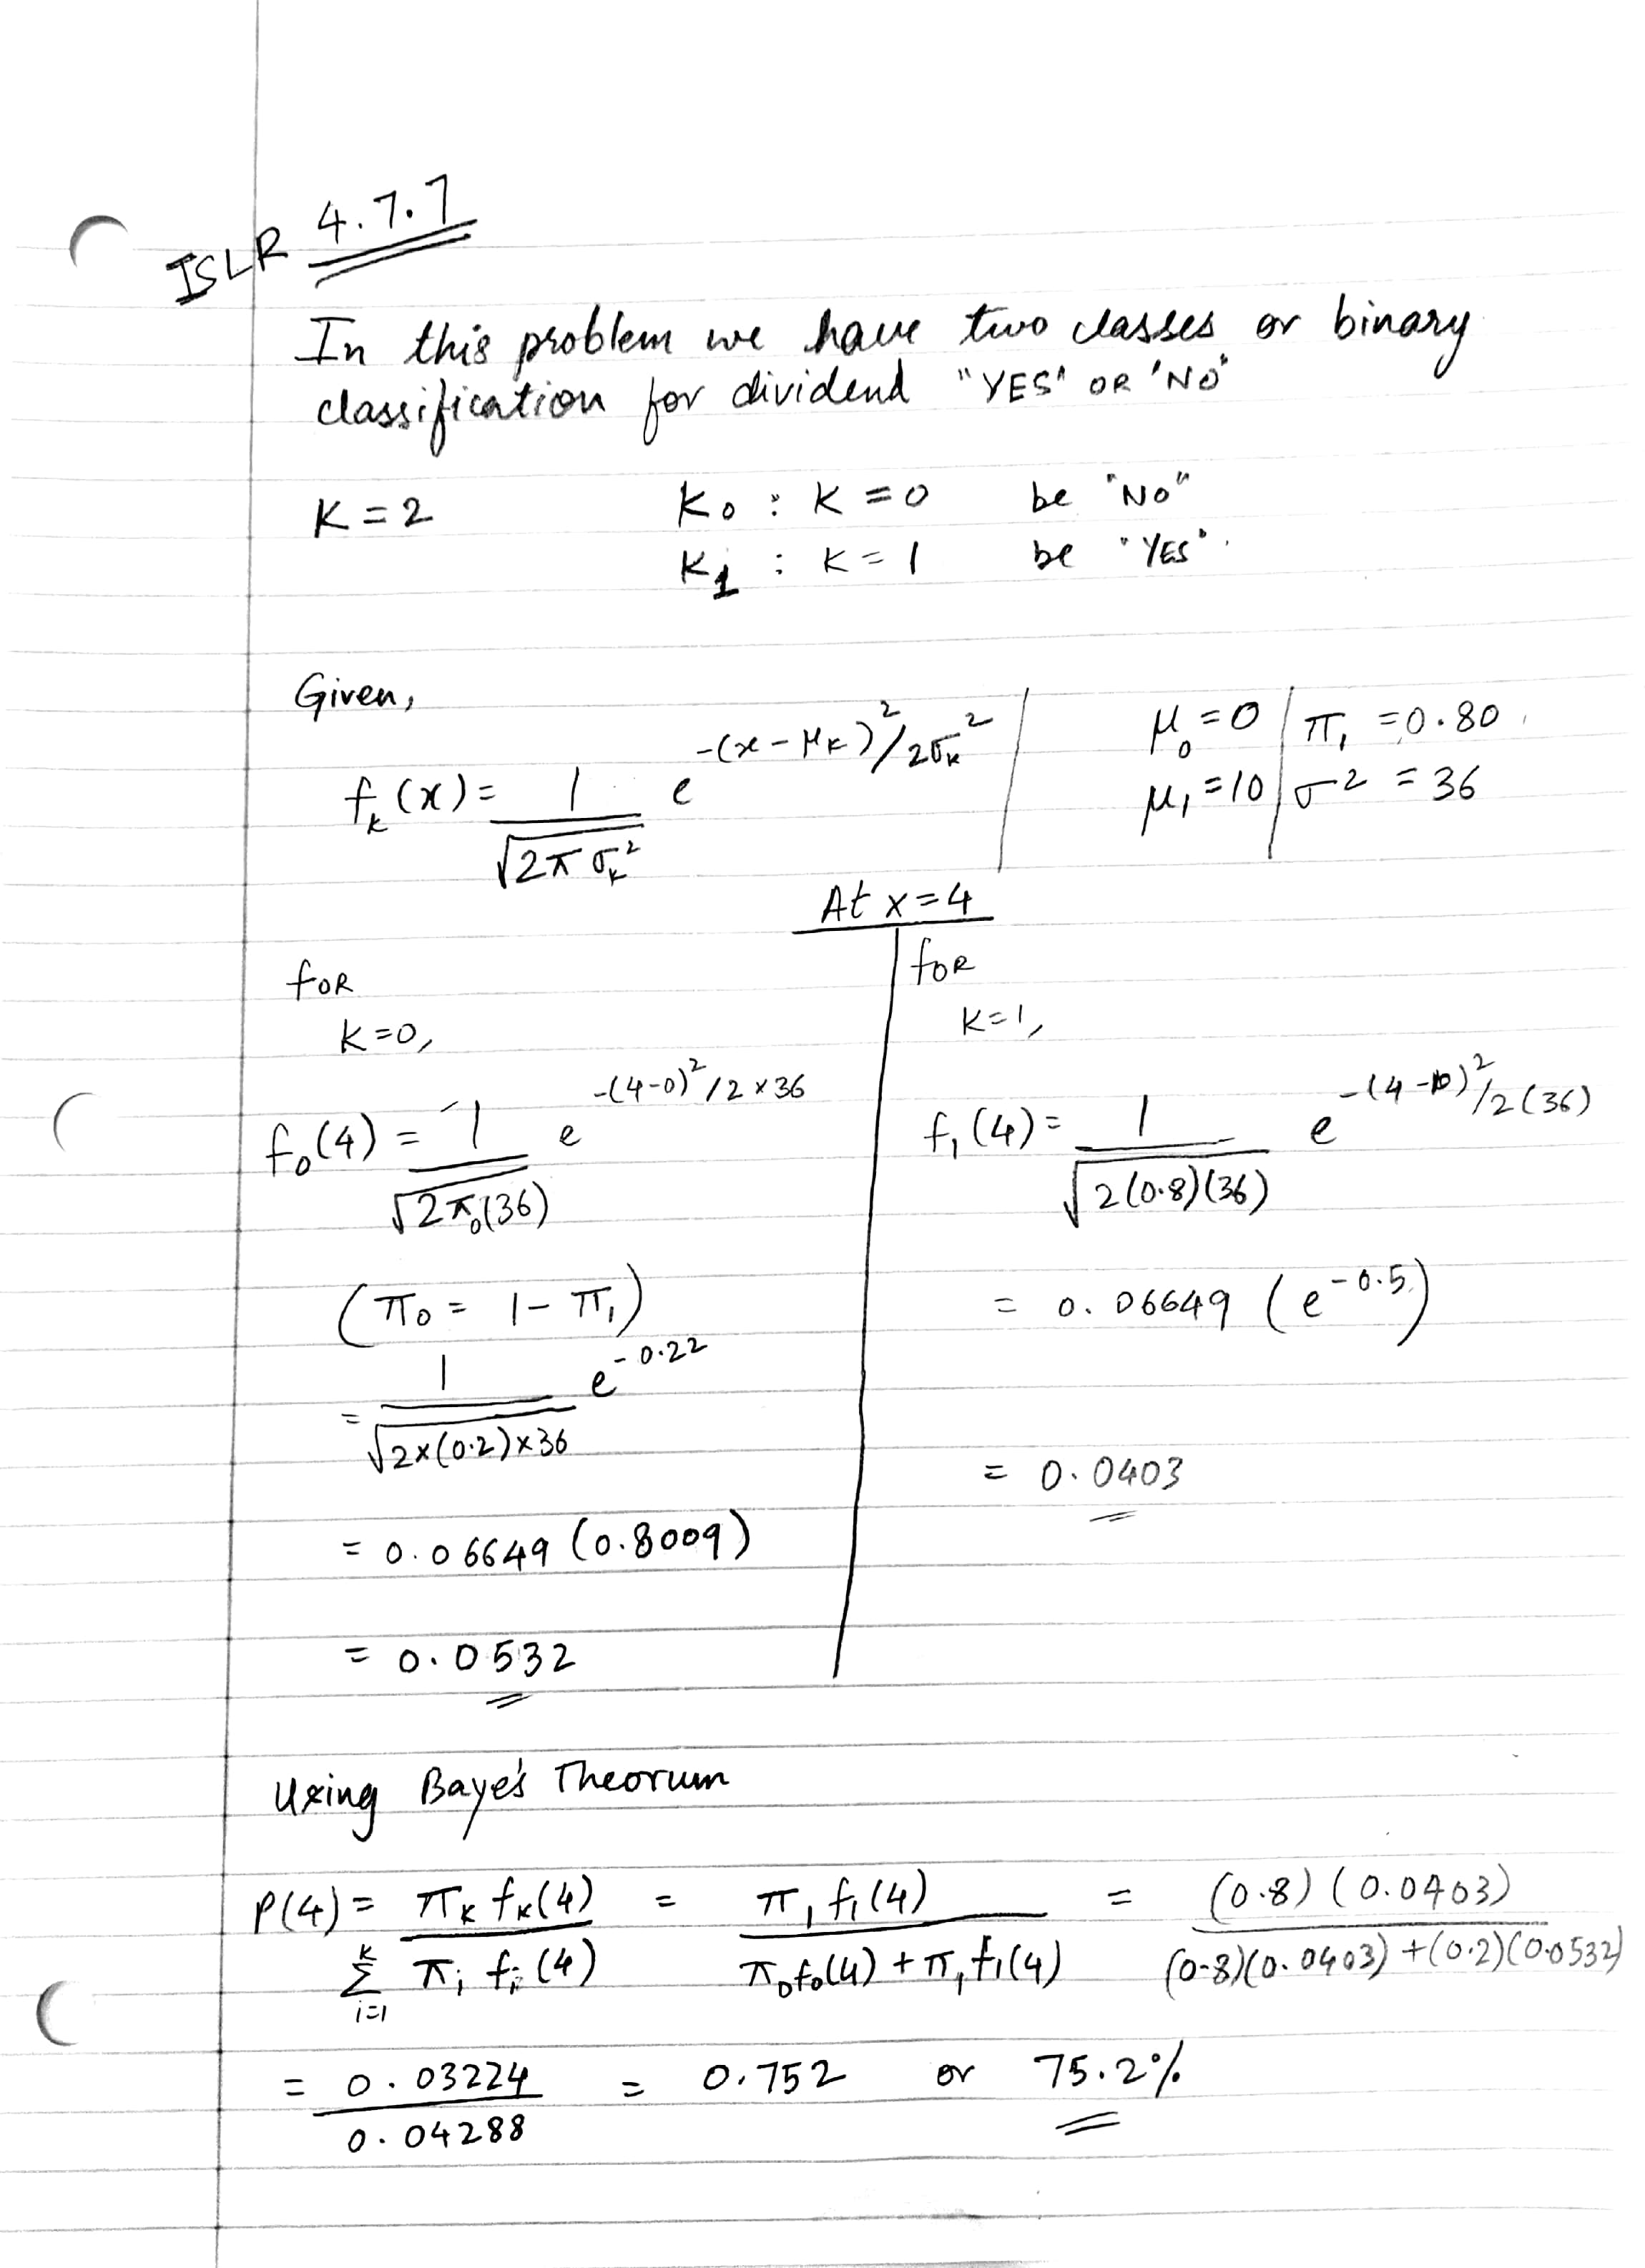

In [347]:
from IPython.display import Image, display; display(Image(filename=r'4.7.7.jpg'))